# Chapter 6 - Sentiment analysis
***

In [1]:
from collections import Counter, OrderedDict
from typing import List, Dict, Tuple, Union, Optional
import json
from bs4 import BeautifulSoup
import string
import numpy as np
import matplotlib.pyplot as plt
import io

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Functions

In [4]:
# remove these words
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

# remove punctuation
table = str.maketrans('', '', string.punctuation)

# Assuming the tokenize function is defined elsewhere
def tokenize(text):
    # Tokenization logic, removing HTML and stopwords as discussed earlier
    soup = BeautifulSoup(text, "html.parser")
    cleaned_text = soup.get_text()
    tokens = cleaned_text.lower().split()
    filtered_tokens = [token for token in tokens if token not in stopwords]
    return filtered_tokens


def build_vocab(sentences, max_vocab_size: Optional[int] = None):
    counter = Counter()
    for text in sentences:
        counter.update(tokenize(text))

    if max_vocab_size is None:
        # Sort words by frequency in descending order
        words = sorted(counter.items(), key=lambda x: x[1], reverse=True)
    else:
        # Take only the top max_vocab_size-1 most frequent words (leave room for special tokens)
        words = counter.most_common(max_vocab_size - 2)  # -2 for <pad> and <unk>

    # Create vocabulary with indices starting from 2
    vocab = {word: idx + 2 for idx, (word, _) in enumerate(words)}
    vocab['<pad>'] = 0  # Add padding token
    if max_vocab_size is not None:
        vocab['<unk>'] = 1  # Add unknown token
    return vocab


def texts_to_sequences(sentences, word_index):
    sequences = []
    for sentence in sentences:
        sequence = []
        for word in sentence.split():
            if word in word_index:
                sequence.append(word_index[word])
        sequences.append(sequence)
    return sequences


def pad_sequences(sequences, max_len):
    padded_sequences = []
    for seq in sequences:
        if len(seq) > max_len:
            padded_seq = seq[:max_len]
        else:
            padded_seq = seq + [0] * (max_len - len(seq))
        padded_sequences.append(padded_seq)
    return padded_sequences


def word_frequency(sentences, word_dict):
    frequency = {word: 0 for word in word_dict}

    for sentence in sentences:
        words = sentence.lower().split()
        for word in words:
            if word in frequency:
                frequency[word] += 1

    return frequency


def plot_training_metrics(train_loss, train_acc, val_loss, val_acc):
    """
    Plot training and validation metrics on two subplots.

    Args:
        train_loss: Array of training loss values
        train_acc: Array of training accuracy values
        val_loss: Array of validation loss values
        val_acc: Array of validation accuracy values
    """
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot epochs on x-axis
    epochs = range(1, len(train_loss) + 1)

    # First subplot: Loss
    ax1.plot(epochs, train_loss, 'b-', label='Training Loss')
    ax1.plot(epochs, val_loss, 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Second subplot: Accuracy
    ax2.plot(epochs, train_acc, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    # Add accuracy percentage labels
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

    # Adjust layout to prevent overlap
    plt.tight_layout()

    return fig

## Configuration

In [13]:
max_vocab_size = 2000       # no. words in the vocabulary
max_length = 85         # maximum length of the sentences
training_size = 23000   # size of the training sample
num_epochs = 300
batch_size = 32
embedding_dim = 7       # dimension of the embeddings
hidden_dim = 8
dropout_rate = 0.25

## Data

### Download

In [ ]:
path_data = Path('/tmp/sarcasm.json')

if path_data.is_file() is False:
    !wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/sarcasm.json \
    -O /tmp/sarcasm.json
else:
    print(f'{path_data} already exists.')

--2025-12-05 11:16:07--  https://storage.googleapis.com/learning-datasets/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.184.187, 142.250.178.187, 142.250.185.27, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.184.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  4.95MB/s    in 1.1s    

2025-12-05 11:16:09 (4.95 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



### Preprocess

In [7]:
# load the data
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

# extract cleaned sentences, labels and URL
sentences = []
labels = []
urls = []
for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

### Tokenize

In [9]:
# max_vocab_size = 2000 # None # number of words in the vocabulary
# max_length =85 #100 # length of the sentences
#trunc_type='post'
#padding_type='post'
#oov_tok = "<OOV>"

# define train and test samples
training_sentences = sentences[:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[:training_size]
testing_labels = labels[training_size:]

# on the train sample: build vocabulary, and create padded sequences
word_index = build_vocab(training_sentences, max_vocab_size=max_vocab_size)
training_sequences = texts_to_sequences(training_sentences, word_index)
training_padded = pad_sequences(training_sequences, max_len=max_length)

# on the test sample: create padded sequences
testing_sequences = texts_to_sequences(testing_sentences, word_index)
testing_padded = pad_sequences(testing_sequences, max_len=max_length)

# compute word frequency
word_freq = word_frequency(training_sentences, word_index)
print(word_freq)

{'new': 1318, 'trump': 1117, 'man': 1075, 'not': 634, 'just': 501, 'will': 484, 'one': 469, 'year': 440, 'report': 434, 'area': 421, 'donald': 407, 'day': 398, 'u': 398, 's': 392, 'can': 387, 'says': 385, 'woman': 378, 'first': 376, 'time': 365, 'like': 356, 'no': 352, 'get': 346, 'old': 332, 'trumps': 331, 'off': 326, 'now': 325, 'life': 319, 'obama': 317, 'people': 311, 'house': 290, 'women': 289, 'white': 281, 'back': 278, 'still': 276, 'make': 275, 'clinton': 264, '5': 260, 'world': 251, 'americans': 246, 'years': 240, 'way': 239, 'family': 231, 'black': 230, 'study': 225, 'gop': 218, 'best': 215, 'bill': 211, 'american': 208, 'school': 207, 'police': 206, 'watch': 206, '3': 205, 'show': 205, 'really': 200, 'president': 198, 'home': 196, 'last': 194, 'video': 194, 'finds': 194, 'death': 193, 'cant': 193, 'know': 193, '10': 192, 'things': 191, 'good': 191, 'going': 190, 'state': 189, 'hillary': 187, 'love': 184, 'nation': 177, 'may': 174, '2': 174, 'health': 172, 'say': 172, 'parent

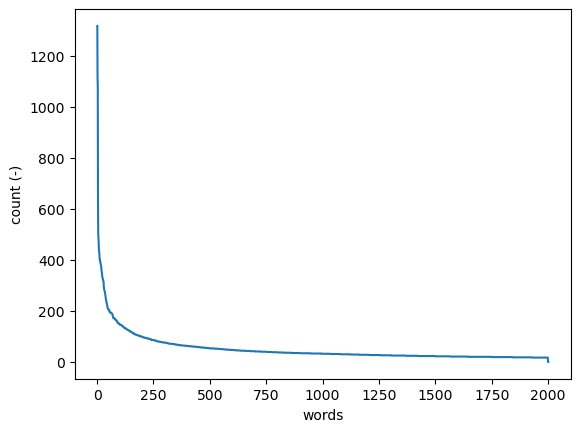

In [10]:
newlist = (OrderedDict(sorted(word_freq.items(), key=lambda t: t[1], reverse=True)))

xs, ys = [], []
curr_x = 1
for item in newlist:
    xs.append(curr_x)
    curr_x += 1
    ys.append(newlist[item])

plt.plot(xs, ys)
plt.xlabel('words')
plt.ylabel('count (-)')
plt.show()

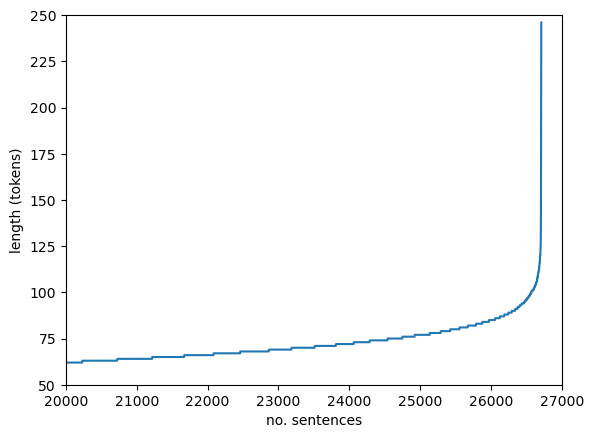

62


In [11]:
xs = []
ys = []
current_item = 1
for item in sentences:
  xs.append(current_item)
  current_item += 1
  ys.append(len(item))
newys = sorted(ys)

plt.plot(xs, newys)
plt.axis([20000, 27000, 50, 250])
plt.xlabel('no. sentences')
plt.ylabel('length (tokens)')
plt.show()

print(newys[20000])


### `DataLoader`

In [12]:
# Convert your preprocessed data to PyTorch tensors
training_padded = torch.tensor(training_padded, dtype=torch.long)
testing_padded = torch.tensor(testing_padded, dtype=torch.long)
training_labels = torch.tensor(training_labels, dtype=torch.float32)
testing_labels = torch.tensor(testing_labels, dtype=torch.float32)

# Create DataLoader objects
train_dataset = TensorDataset(training_padded, training_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(testing_padded, testing_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Model

### Architecture

In [14]:
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim=24, dropout_rate=0):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(1, 2)  # Change for pooling layer
        x = self.global_pool(x).squeeze(2)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.sigmoid(self.fc2(x))
        return x

In [17]:
# Model parameters
vocab_size = len(word_index)
# if max_vocab_size is None:
#     vocab_size += 1  # Add 1 for padding token
# else:
#     vocab_size += 2 # Add 2 for padding and unknown tokens

# Initialize the model
model = TextClassificationModel(vocab_size, embedding_dim, hidden_dim, dropout_rate)
model = model.to(device)

summary(model,
        input_size=(batch_size, max_length),
        dtypes=[torch.long],  # Specify long dtype for embedding layer
        device=device)

Layer (type:depth-idx)                   Output Shape              Param #
TextClassificationModel                  [32, 1]                   --
├─Embedding: 1-1                         [32, 85, 7]               14,000
├─AdaptiveAvgPool1d: 1-2                 [32, 7, 1]                --
├─Linear: 1-3                            [32, 8]                   64
├─ReLU: 1-4                              [32, 8]                   --
├─Dropout: 1-5                           [32, 8]                   --
├─Linear: 1-6                            [32, 1]                   9
├─Sigmoid: 1-7                           [32, 1]                   --
Total params: 14,073
Trainable params: 14,073
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.45
Input size (MB): 0.02
Forward/backward pass size (MB): 0.15
Params size (MB): 0.06
Estimated Total Size (MB): 0.23

### Train

In [18]:
# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), amsgrad=False)#, weight_decay=0.01)
# optimizer = optim.Adam([
#     {'params': model.fc1.parameters(), 'weight_decay': 0.01},
#     {'params': [p for name, p in model.named_parameters() if 'fc1' not in name]}
# ])

# Training loop
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_total += targets.size(0)
        train_correct += ((outputs.squeeze() > 0.5) == targets).sum().item()

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)

            val_loss += loss.item()
            val_total += targets.size(0)
            val_correct += ((outputs.squeeze() > 0.5) == targets).sum().item()

    print(f'Epoch {epoch + 1}/{num_epochs}:')
    train_loss_history.append(train_loss / len(train_loader))
    train_acc_history.append(train_correct / train_total)
    val_loss_history.append(val_loss / len(test_loader))
    val_acc_history.append(val_correct / val_total)
    print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_correct/train_total:.4f}')
    print(f'Val Loss: {val_loss/len(test_loader):.4f}, Val Acc: {val_correct/val_total:.4f}')

Epoch 1/300:
Train Loss: 0.7062, Train Acc: 0.4978
Val Loss: 0.6869, Val Acc: 0.5700
Epoch 2/300:
Train Loss: 0.6951, Train Acc: 0.5179
Val Loss: 0.6838, Val Acc: 0.5700
Epoch 3/300:
Train Loss: 0.6932, Train Acc: 0.5288
Val Loss: 0.6835, Val Acc: 0.5700
Epoch 4/300:
Train Loss: 0.6912, Train Acc: 0.5391
Val Loss: 0.6832, Val Acc: 0.5700
Epoch 5/300:
Train Loss: 0.6914, Train Acc: 0.5426
Val Loss: 0.6833, Val Acc: 0.5700
Epoch 6/300:
Train Loss: 0.6906, Train Acc: 0.5421
Val Loss: 0.6833, Val Acc: 0.5700
Epoch 7/300:
Train Loss: 0.6905, Train Acc: 0.5414
Val Loss: 0.6835, Val Acc: 0.5700
Epoch 8/300:
Train Loss: 0.6883, Train Acc: 0.5452
Val Loss: 0.6831, Val Acc: 0.5700
Epoch 9/300:
Train Loss: 0.6871, Train Acc: 0.5504
Val Loss: 0.6830, Val Acc: 0.5700
Epoch 10/300:
Train Loss: 0.6873, Train Acc: 0.5482
Val Loss: 0.6830, Val Acc: 0.5700
Epoch 11/300:
Train Loss: 0.6880, Train Acc: 0.5487
Val Loss: 0.6828, Val Acc: 0.5700
Epoch 12/300:
Train Loss: 0.6873, Train Acc: 0.5531
Val Loss: 0

### Analyse results

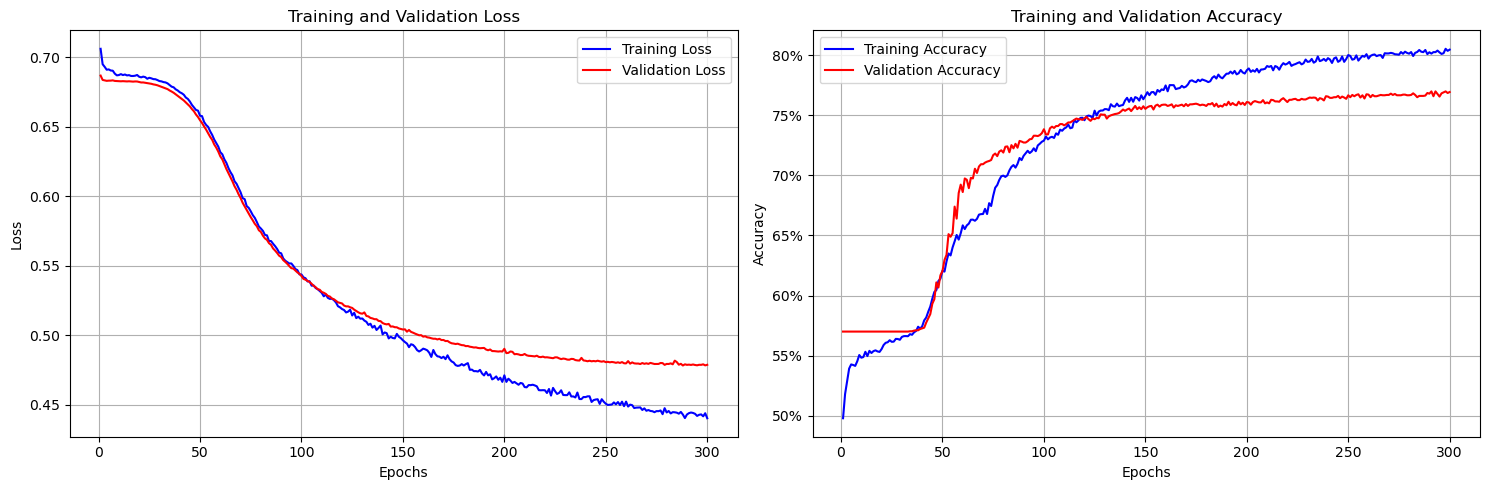

In [19]:
# plot evolution of accuracy and loss in the train and validation sets
_ = plot_training_metrics(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

In [22]:
# After training, you can save the model
torch.save(model.state_dict(), 'text_classification_model.pth')

## Inference

In [23]:
def predict_sentences(model, sentences, vocab, max_len, device='cuda', threshold=0.5):
    """
    Make predictions for new sentences and interpret results
    """
    # convert text to sequences
    sequences = texts_to_sequences(test_sentences, word_index)
    # pad sequences
    padded = pad_sequences(sequences, max_length)
    # convert to tensor
    input_ids = torch.tensor(padded, dtype=torch.long).to(device)

    # predict
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids)
    probabilities = outputs.squeeze().cpu().numpy()
    predictions = (probabilities >= 0.5).astype(int)

    # Print results
    for sentence, prob, pred in zip(sentences, probabilities, predictions):
        print(f"\nText: {sentence}")
        print(f"Probability: {prob:.4f}")
        print(f"Classification: {'Sarcastic' if pred == 1 else 'Not Sarcastic'}")
        print(f"Confidence: {max(prob, 1-prob):.4f}")
        print("-" * 80)

In [24]:
test_sentences = [
    'granny starting to fear spiders in the garden might be real',
    'game of thrones season finale showing this sunday night',
    'PyTorch book will be a best seller'
]

In [25]:
predict_sentences(
    model=model,
    sentences=test_sentences,
    vocab=word_index,
    max_len=max_length,
    device=device,
    threshold=0.5
)


Text: granny starting to fear spiders in the garden might be real
Probability: 0.5128
Classification: Sarcastic
Confidence: 0.5128
--------------------------------------------------------------------------------

Text: game of thrones season finale showing this sunday night
Probability: 0.0602
Classification: Not Sarcastic
Confidence: 0.9398
--------------------------------------------------------------------------------

Text: PyTorch book will be a best seller
Probability: 0.1205
Classification: Not Sarcastic
Confidence: 0.8795
--------------------------------------------------------------------------------


### Explore embeddings

In [26]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
embedding_weights = model.embedding.weight.data.cpu().numpy()

In [27]:
idx = 2
print(reverse_word_index[idx])
print(embedding_weights[2])

new
[ 1.0525806  -0.71503174  0.45637017 -0.1951434   0.53449476 -1.710847
 -0.30264294]


In [28]:
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = embedding_weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()